# Import Package

In [1]:
import tensorflow as tf
import os
import io
import zipfile
from zipfile import ZipFile
from PIL import Image
from io import BytesIO
import numpy as np

from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor

In [3]:
r_seed = 0
np.random.seed(r_seed)

omniglot_data_path = '/home/tianyliu/Data/OpenSet/Dataset/omniglot/python/images_evaluation.zip'

sample_size = 10000
# print(sample_size)

# Preparing Data

## MNIST and MNIST-Noise

In [5]:
mnist = tf.keras.datasets.mnist

(x_mnist_train, y_mnist_train), (x_mnist_test,
                                 y_mnist_test) = mnist.load_data()
x_mnist_train, x_mnist_test = x_mnist_train / 255.0, x_mnist_test / 255.0

# introduce noise to mnist
x_mnist_noise_test = x_mnist_test.copy()
random_noise = np.random.uniform(
    0, 1, x_mnist_noise_test[np.where(x_mnist_noise_test == 0)].shape[0])
x_mnist_noise_test[np.where(x_mnist_noise_test == 0)] = random_noise

In [6]:
# 0 - 9 | 10
# 0 - 10  where 10 means not exists in trianing data
# the 

In [7]:
for i in range(4):
    im = Image.fromarray(np.uint8(x_mnist_test[i]*255))
    display(im)
    
for i in range(4):
    im = Image.fromarray(np.uint8(x_mnist_noise_test[i]*255))
    display(im)

## Omniglot

In [8]:
def load_omniglot_eval(data_path):
    omniglot_data_list = []
    with zipfile.ZipFile(data_path) as zf:
        for filename in zf.namelist():
            if '.png' in filename:
                zip_data = zf.read(filename)
                bytes_io = BytesIO(zip_data)
                pil_img = Image.open(bytes_io)
                pil_img = pil_img.resize((28, 28))
                omniglot_data_list.append([1 - np.array(pil_img) * 1.0])

    omniglot_data = np.concatenate(omniglot_data_list)
    return omniglot_data


omniglot_data = load_omniglot_eval(omniglot_data_path)
sample_idx = np.random.permutation(omniglot_data.shape[0])[:sample_size]
x_omniglot_test = omniglot_data[sample_idx]
print(omniglot_data.shape)

(13180, 28, 28)


In [9]:
for i in range(4):
    im = Image.fromarray(np.uint8(x_omniglot_test[i]*255))
    display(im)

## Noise

In [10]:
x_noise_test = np.random.uniform(0, 1, (sample_size, 28, 28))

In [11]:
for i in range(4):
    im = Image.fromarray(np.uint8(x_noise_test[i]*255))
    display(im)

# Build Classifcation Model

In [12]:
# from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Conv2D, Lambda, MaxPooling2D  # convolution layers
# from keras.layers import Dense, Dropout, Flatten  # core layers
# from keras.layers.normalization import BatchNormalization
from keras import backend as K

In [13]:
tf.random.set_seed(0)

In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [15]:
# basic_model structure
# basic_model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10),
#     tf.keras.layers.Activation(activation='softmax')
# ])

basic_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=100,
                           kernel_size=(3, 3),
                           activation="relu",
                           input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(4), # layer -3
    tf.keras.layers.Dense(10), # layer -2
    tf.keras.layers.Activation(activation='softmax') # layer -1
])

basic_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [16]:
# set layer output as a second Model
model_l2 = tf.keras.models.Model(inputs=basic_model.layers[0].input,
                              outputs=basic_model.layers[-2].output)

# set layer output as a second Model
model_l3 = tf.keras.models.Model(inputs=basic_model.layers[0].input,
                              outputs=basic_model.layers[-3].output)

In [17]:
x_mnist_train = x_mnist_train.reshape(-1, 28, 28, 1)
x_mnist_test = x_mnist_test.reshape(-1, 28, 28, 1)

In [18]:
K.set_value(basic_model.optimizer.learning_rate, 0.001)

basic_model.fit(x_mnist_train, y_mnist_train, epochs=5)
basic_model.evaluate(x_mnist_test, y_mnist_test, verbose=2)

Epoch 1/5
1875/1875 [==============================] - 59s 31ms/step - loss: 0.4516 - accuracy: 0.8644
Epoch 2/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0659 - accuracy: 0.9818
Epoch 3/5
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0493 - accuracy: 0.9859
Epoch 4/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0361 - accuracy: 0.9896
Epoch 5/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0291 - accuracy: 0.9912
313/313 - 2s - loss: 0.0451 - accuracy: 0.9868


[0.04506460949778557, 0.9868000149726868]

In [46]:
# K.set_value(basic_model.optimizer.learning_rate, 0.0001)
# basic_model.fit(x_mnist_train, y_mnist_train, epochs=5)
# basic_model.evaluate(x_mnist_test, y_mnist_test, verbose=2)

In [47]:
# K.set_value(basic_model.optimizer.learning_rate, 0.0001)
# basic_model.fit(x_mnist_train, y_mnist_train, epochs=5)
# basic_model.evaluate(x_mnist_test, y_mnist_test, verbose=2)

In [48]:
# K.set_value(basic_model.optimizer.learning_rate, 0.00001)
# basic_model.fit(x_mnist_train, y_mnist_train, epochs=10)
# basic_model.evaluate(x_mnist_test, y_mnist_test, verbose=2)

# Making Prediction

In [19]:
x_mnist_test = x_mnist_test.reshape(-1, 28, 28, 1)
x_omniglot_test = x_omniglot_test.reshape(-1, 28, 28, 1)
x_mnist_noise_test = x_mnist_noise_test.reshape(-1, 28, 28, 1)
x_noise_test = x_noise_test.reshape(-1, 28, 28, 1)

result_mnist_test = model.predict(x_mnist_test[:sample_size])
result_omniglot_test = model.predict(x_omniglot_test)
result_mnist_noise_test = model.predict(x_mnist_noise_test[:sample_size])
result_noise_test = model.predict(x_noise_test)

result_mnist_test_base = basic_model.predict(x_mnist_test[:sample_size])
result_omniglot_test_base = basic_model.predict(x_omniglot_test)
result_mnist_noise_test_base = basic_model.predict(
    x_mnist_noise_test[:sample_size])
result_noise_test_base = basic_model.predict(x_noise_test)

result_mnist_test_mlayer = np.hstack(
    [result_mnist_test, result_mnist_test_base])
result_omniglot_test_mlayer = np.hstack(
    [result_omniglot_test, result_omniglot_test_base])
result_mnist_noise_test_mlayer = np.hstack(
    [result_mnist_noise_test, result_mnist_noise_test_base])
result_noise_test_mlayer = np.hstack(
    [result_noise_test, result_noise_test_base])

NameError: name 'model' is not defined

NameError: name 'result_mnist_test_base' is not defined

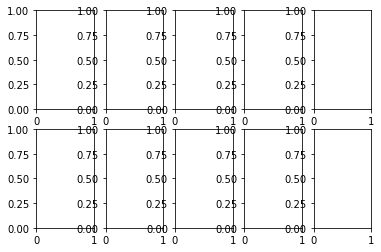

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=5)

counter = 0
for row in ax:
    for col in row:
        col.hist(result_mnist_test_base[:, counter])
        col.hist(result_omniglot_test_base[:, counter])
        counter += 1
plt.show()

NameError: name 'result_mnist_test' is not defined

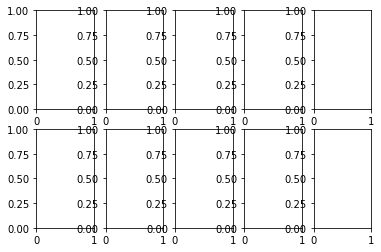

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=5)

counter = 0
for row in ax:
    for col in row:
        col.hist(result_mnist_test[:, counter])
        col.hist(result_omniglot_test[:, counter])
        counter += 1
plt.show()

NameError: name 'result_mnist_test' is not defined

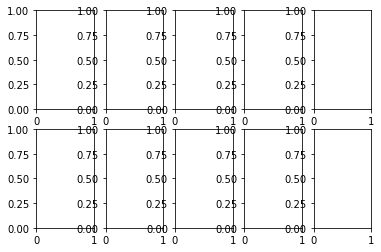

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=5)

counter = 0
for row in ax:
    for col in row:
        col.hist(result_mnist_test[:, counter])
        col.hist(result_mnist_noise_test[:, counter])
        counter += 1
plt.show()

NameError: name 'result_mnist_test' is not defined

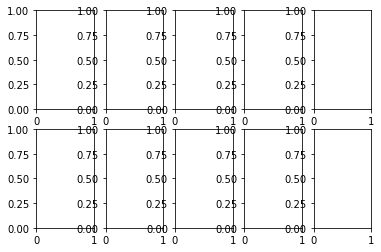

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=5)

counter = 0
for row in ax:
    for col in row:
        col.hist(result_mnist_test[:, counter])
        col.hist(result_noise_test[:, counter])
        counter += 1
plt.show()

# Multi-layer Ensemble

In [56]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [57]:
result_mnist_train = model.predict(x_mnist_train)
result_mnist_train_base = basic_model.predict(x_mnist_train)

NameError: name 'model' is not defined

In [58]:
sample_size = 10000
outlier_detector_l1 = IsolationForest(random_state=r_seed, n_estimators=1000, verbose=0, max_samples = 10000,contamination=0.05)
outlier_detector_l2 = IsolationForest(random_state=r_seed, n_estimators=1000, verbose=0, max_samples = 10000,contamination=0.05)

outlier_detector_l1.fit(result_mnist_train)
outlier_detector_l2.fit(result_mnist_train_base)

outlier_mnist = outlier_detector_l1.predict(result_mnist_test)
outlier_omniglot = outlier_detector_l1.predict(result_omniglot_test)
outlier_mnist_noise = outlier_detector_l1.predict(result_mnist_noise_test)
outlier_noise = outlier_detector_l1.predict(result_noise_test)

outlier_mnist += outlier_detector_l2.predict(result_mnist_test_base)
outlier_omniglot += outlier_detector_l2.predict(result_omniglot_test_base)
outlier_mnist_noise += outlier_detector_l2.predict(result_mnist_noise_test_base)
outlier_noise += outlier_detector_l2.predict(result_noise_test_base)

outlier_mnist[outlier_mnist <= 1] = -1
outlier_mnist[outlier_mnist > 1] = 0
outlier_mnist[outlier_mnist==0] = result_mnist_test_base.argmax(axis=1)[outlier_mnist==0]

outlier_omniglot[outlier_omniglot <= 1] = -1
outlier_omniglot[outlier_omniglot > 1] = 0
outlier_omniglot[outlier_omniglot==0] = result_omniglot_test_base.argmax(axis=1)[outlier_omniglot==0]

outlier_mnist_noise[outlier_mnist_noise <= 1] = -1
outlier_mnist_noise[outlier_mnist_noise > 1] = 0
outlier_mnist_noise[outlier_mnist_noise==0] = result_mnist_noise_test_base.argmax(axis=1)[outlier_mnist_noise==0]


outlier_noise[outlier_noise <= 1] = -1
outlier_noise[outlier_noise > 1] = 0
outlier_noise[outlier_noise==0] = result_noise_test_base.argmax(axis=1)[outlier_noise==0]
    
print('mnist detection rate:', (outlier_mnist == -1).sum()/outlier_mnist.shape[0])
print('omniglot detection rate:', (outlier_omniglot == -1).sum()/outlier_omniglot.shape[0])
print('mnist_noise detection rate:', (outlier_mnist_noise == -1).sum()/outlier_mnist_noise.shape[0])
print('noise detection rate:', (outlier_noise == -1).sum()/outlier_noise.shape[0])

base_pred = result_mnist_test_base.argmax(axis=1)
base_pred[outlier_mnist==-1] = -1

true_label = np.zeros(sample_size*2)
true_label = true_label - 1
true_label[:sample_size] = y_mnist_test

omniglot_f1 = f1_score(true_label, np.concatenate([base_pred,outlier_omniglot]), average='macro')
mnist_noise_f1 = f1_score(true_label, np.concatenate([base_pred,outlier_mnist_noise]), average='macro')
noise_f1 = f1_score(true_label, np.concatenate([base_pred,outlier_noise]), average='macro')

playground_result = pd.DataFrame()
playground_result['detector'] = ['IsolationForest']
playground_result['omniglot'] = [omniglot_f1]
playground_result['mnist_noise'] = [mnist_noise_f1]
playground_result['noise'] = [noise_f1]

playground_result

NameError: name 'result_mnist_train' is not defined

In [23]:
outlier_detector_l1 = IsolationForest(random_state=r_seed, n_estimators=1000, verbose=0, max_samples = 10000)
outlier_detector_l2 = IsolationForest(random_state=r_seed, n_estimators=1000, verbose=0, max_samples = 10000)

outlier_detector_l1.fit(result_mnist_train)
outlier_detector_l2.fit(result_mnist_train_base)

outlier_mnist = outlier_detector_l1.predict(result_mnist_test)
outlier_omniglot = outlier_detector_l1.predict(result_omniglot_test)
outlier_mnist_noise = outlier_detector_l1.predict(result_mnist_noise_test)
outlier_noise = outlier_detector_l1.predict(result_noise_test)

outlier_mnist += outlier_detector_l2.predict(result_mnist_test_base)
outlier_omniglot += outlier_detector_l2.predict(result_omniglot_test_base)
outlier_mnist_noise += outlier_detector_l2.predict(result_mnist_noise_test_base)
outlier_noise += outlier_detector_l2.predict(result_noise_test_base)

outlier_mnist[outlier_mnist <= 1] = -1
outlier_mnist[outlier_mnist > 1] = 0
outlier_mnist[outlier_mnist==0] = result_mnist_test_base.argmax(axis=1)[outlier_mnist==0]

outlier_omniglot[outlier_omniglot <= 1] = -1
outlier_omniglot[outlier_omniglot > 1] = 0
outlier_omniglot[outlier_omniglot==0] = result_omniglot_test_base.argmax(axis=1)[outlier_omniglot==0]

outlier_mnist_noise[outlier_mnist_noise <= 1] = -1
outlier_mnist_noise[outlier_mnist_noise > 1] = 0
outlier_mnist_noise[outlier_mnist_noise==0] = result_mnist_noise_test_base.argmax(axis=1)[outlier_mnist_noise==0]


outlier_noise[outlier_noise <= 1] = -1
outlier_noise[outlier_noise > 1] = 0
outlier_noise[outlier_noise==0] = result_noise_test_base.argmax(axis=1)[outlier_noise==0]
    
print('mnist detection rate:', (outlier_mnist == -1).sum()/outlier_mnist.shape[0])
print('omniglot detection rate:', (outlier_omniglot == -1).sum()/outlier_omniglot.shape[0])
print('mnist_noise detection rate:', (outlier_mnist_noise == -1).sum()/outlier_mnist_noise.shape[0])
print('noise detection rate:', (outlier_noise == -1).sum()/outlier_noise.shape[0])

base_pred = result_mnist_test_base.argmax(axis=1)
base_pred[outlier_mnist==-1] = -1

true_label = np.zeros(sample_size*2)
true_label = true_label - 1
true_label[:sample_size] = y_mnist_test

omniglot_f1 = f1_score(true_label, np.concatenate([base_pred,outlier_omniglot]), average='macro')
mnist_noise_f1 = f1_score(true_label, np.concatenate([base_pred,outlier_mnist_noise]), average='macro')
noise_f1 = f1_score(true_label, np.concatenate([base_pred,outlier_noise]), average='macro')

playground_result = pd.DataFrame()
playground_result['detector'] = ['IsolationForest']
playground_result['omniglot'] = [omniglot_f1]
playground_result['mnist_noise'] = [mnist_noise_f1]
playground_result['noise'] = [noise_f1]

playground_result

mnist detection rate: 0.1964
omniglot detection rate: 0.8371
mnist_noise detection rate: 0.9172
noise detection rate: 0.9999


,detector,omniglot,mnist_noise,noise
0,IsolationForest,0.81805,0.859103,0.889453


# Openset Sample Enrichment

In [13]:
import os
import sys
import numpy as np 
import math
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
%matplotlib inline
from sklearn.metrics import pairwise_distances

# an implementation of Kernel Mean Matchin
# referenres:
#  1. Gretton, Arthur, et al. "Covariate shift by kernel mean matching." Dataset shift in machine learning 3.4 (2009): 5.
#  2. Huang, Jiayuan, et al. "Correcting sample selection bias by unlabeled data." Advances in neural information processing systems. 2006.
def kernel_mean_matching(X, Z, kern='lin', B=1.0, eps=None):
    nx = X.shape[0]
    nz = Z.shape[0]
    if eps == None:
        eps = B/math.sqrt(nz)
    if kern == 'lin':
        K = np.dot(Z, Z.T)
        kappa = np.sum(np.dot(Z, X.T)*float(nz)/float(nx),axis=1)
    elif kern == 'rbf':
        K = compute_rbf(Z,Z)
        kappa = np.sum(compute_rbf(Z,X),axis=1)*float(nz)/float(nx)
    else:
        raise ValueError('unknown kernel')
        
    K = matrix(K)
    kappa = matrix(kappa)
    G = matrix(np.r_[np.ones((1,nz)), -np.ones((1,nz)), np.eye(nz), -np.eye(nz)])
    h = matrix(np.r_[nz*(1+eps), nz*(eps-1), B*np.ones((nz,)), np.zeros((nz,))])
    
    sol = solvers.qp(K, -kappa, G, h)
    coef = np.array(sol['x'])
    return coef

def compute_rbf(X, Z):
    sigma = pairwise_distances(X).std()
    sigma = sigma**2
    print(sigma)
    K = np.zeros((X.shape[0], Z.shape[0]), dtype=float)
    for i, vx in enumerate(X):
        K[i,:] = np.exp(-np.sum((vx-Z)**2, axis=1)/(2.0*sigma))
    return K

def sample_enrichment(r_seed, target_data, sample_size):
    np.random.seed(r_seed)
    domain_max = target_data.max(axis=0)
    domain_min = target_data.min(axis=0)
    domain_dim = target_data.shape[1]

    sample_enri = np.random.random(size=(sample_size, domain_dim))

    domain_gap = (domain_max - domain_min) * 1.2
    domain_mean = (domain_max + domain_min) / 2

    for dim_idx in range(domain_dim):
        sample_enri[:, dim_idx] = sample_enri[:, dim_idx] * domain_gap[
            dim_idx] + domain_mean[dim_idx] - domain_gap[dim_idx] / 2
        
    sample_coef = kernel_mean_matching(target_data, sample_enri, kern='rbf', B=50)
    return sample_enri, np.squeeze(sample_coef)

# sample_enrichment testing

# target_data = np.random.normal(15, 1, (1000, 2))
# sample_size = 2000

# sample_enri, sample_coef = sample_enrichment(1, target_data, sample_size)
# sample_label = np.ones(sample_size)
# sample_label[np.squeeze(sample_coef < 0.5)] = -1
    
# plt.scatter(sample_enri[:, 0], sample_enri[:, 1])
# plt.scatter(target_data[:, 0], target_data[:, 1])
# plt.show()

# plt.scatter(sample_enri[sample_label==-1, 0], sample_enri[sample_label==-1, 1])
# plt.scatter(sample_enri[sample_label==1, 0], sample_enri[sample_label==1, 1])
# plt.show()

# Openset Detection

In [429]:
x_mnist_test = x_mnist_test.reshape(-1, 28, 28, 1)
x_omniglot_test = x_omniglot_test.reshape(-1, 28, 28, 1)
x_mnist_noise_test = x_mnist_noise_test.reshape(-1, 28, 28, 1)
x_noise_test = x_noise_test.reshape(-1, 28, 28, 1)

mniTr_l3_r = model_l3.predict(x_mnist_train)
mniTe_l3_r = model_l3.predict(x_mnist_test)
omnig_l3_r = model_l3.predict(x_omniglot_test)
mniNo_l3_r = model_l3.predict(x_mnist_noise_test)
noise_l3_r = model_l3.predict(x_noise_test)

# mniTr_l3_r = model_l2.predict(x_mnist_train)
# mniTe_l3_r = model_l2.predict(x_mnist_test)
# omnig_l3_r = model_l2.predict(x_omniglot_test)
# mniNo_l3_r = model_l2.predict(x_mnist_noise_test)
# noise_l3_r = model_l2.predict(x_noise_test)


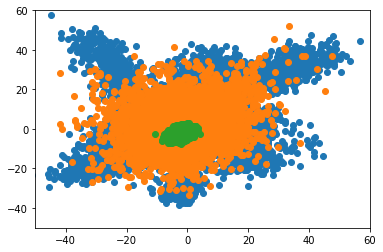

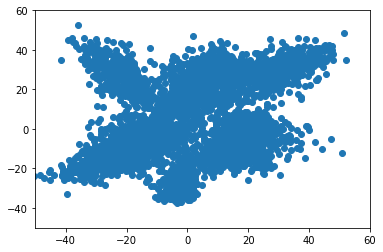

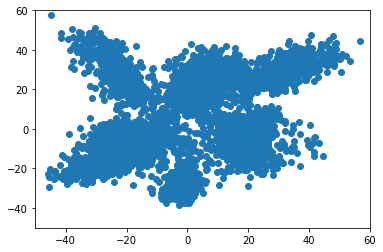

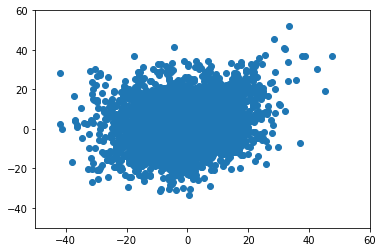

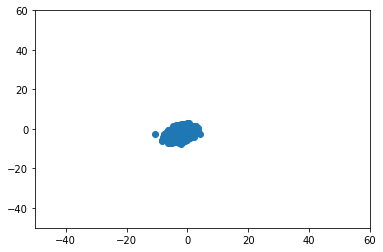

In [433]:
idx1 = 1
idx2 = 2
plt.scatter(mniTr_l3_r[:5000, idx1], mniTr_l3_r[:5000, idx2])
plt.scatter(omnig_l3_r[:5000, idx1], omnig_l3_r[:5000, idx2])
plt.scatter(noise_l3_r[:5000, idx1], noise_l3_r[:5000, idx2])
plt.ylim([-50, 60])
plt.xlim([-50, 60])
plt.show()

plt.scatter(mniTe_l3_r[:5000, idx1], mniTe_l3_r[:5000, idx2])
plt.ylim([-50, 60])
plt.xlim([-50, 60])
plt.show()

plt.scatter(mniTr_l3_r[:5000, idx1], mniTr_l3_r[:5000, idx2])
plt.ylim([-50, 60])
plt.xlim([-50, 60])
plt.show()

plt.scatter(omnig_l3_r[:5000, idx1], omnig_l3_r[:5000, idx2])
plt.ylim([-50, 60])
plt.xlim([-50, 60])
plt.show()

plt.scatter(noise_l3_r[:5000, idx1], noise_l3_r[:5000, idx2])
plt.ylim([-50, 60])
plt.xlim([-50, 60])
plt.show()

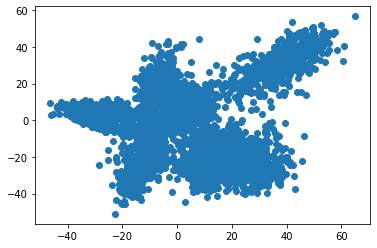

1049.9702333823388
1049.9702333823388
     pcost       dcost       gap    pres   dres
 0: -5.5958e+06 -1.1607e+09  1e+09  4e-02  2e-15
 1: -5.2056e+06 -1.1156e+09  1e+09  4e-02  3e-15
 2: -2.2691e+06 -9.6635e+08  1e+09  2e-02  1e-14
 3: -2.9661e+06 -6.6045e+07  6e+07  2e-15  3e-14
 4: -3.3247e+06 -2.8764e+07  3e+07  9e-16  4e-15
 5: -3.4028e+06 -2.8812e+07  3e+07  3e-15  4e-15
 6: -3.5221e+06 -2.8645e+07  3e+07  2e-15  4e-15
 7: -3.5984e+06 -2.8398e+07  2e+07  8e-16  3e-15
 8: -4.1001e+06 -2.6099e+07  2e+07  2e-15  3e-15
 9: -4.5806e+06 -2.1821e+07  2e+07  2e-15  1e-15
10: -4.9752e+06 -1.4162e+07  9e+06  6e-16  1e-15
11: -5.1792e+06 -9.4000e+06  4e+06  8e-16  7e-16
12: -5.3177e+06 -6.8394e+06  2e+06  9e-16  5e-16
13: -5.4567e+06 -6.2646e+06  8e+05  2e-15  4e-16
14: -5.4672e+06 -6.2365e+06  8e+05  2e-15  4e-16
15: -5.4968e+06 -6.1122e+06  6e+05  6e-16  4e-16
16: -5.5379e+06 -5.9064e+06  4e+05  9e-16  4e-16
17: -5.5647e+06 -5.7754e+06  2e+05  1e-15  4e-16
18: -5.5833e+06 -5.6911e+06  1e+

In [434]:
plt.scatter(mniTr_l3_r[:5000, 0], mniTr_l3_r[:5000, 1])
plt.show()

q_sample_list = []
q_weight_list = []

for i in range(2):
    temp_enri, temp_coef = sample_enrichment(i, mniTr_l3_r[i*6000:(i+1)*6000], 6000)
    q_sample_list.append(temp_enri)
    q_weight_list.append(temp_coef)

In [509]:
q_sample = np.vstack(q_sample_list)
q_weight = np.hstack(q_weight_list)

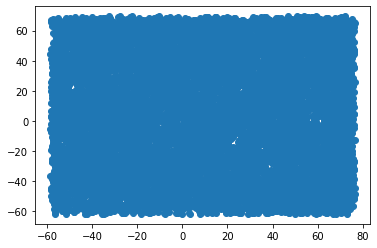

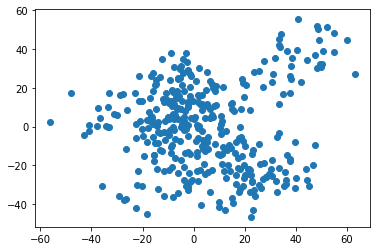

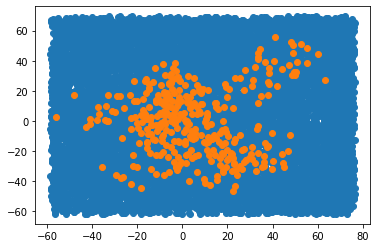

In [510]:
theta = 0.005
cond1 = (q_weight < theta)
cond2 = (q_weight >= theta)

plt.scatter(q_sample[cond1, 0], q_sample[cond1, 1])
# plt.scatter(omnig_l3_r[:5000, 0], omnig_l3_r[:5000, 1])
plt.show()
plt.scatter(q_sample[cond2, 0], q_sample[cond2, 1])
plt.show()

plt.scatter(q_sample[cond1, 0], q_sample[cond1, 1])
plt.scatter(q_sample[cond2, 0], q_sample[cond2, 1])
plt.show()

In [550]:
q_sample = np.vstack(q_sample_list)
q_weight = np.hstack(q_weight_list)

beta = 0.5
tau = 0.2
cond1 = (q_weight <= tau)
cond2 = (q_weight >= 2*tau)
cond3 = (q_weight > tau) & (q_weight < 2*tau)
q_weight[cond1] = q_weight[cond1] + beta
q_weight[cond3] = (1-beta/tau)*q_weight[cond3] + 2*beta

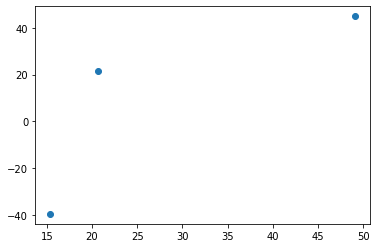

In [551]:
theta = 1
cond1 = (q_weight < beta)
plt.scatter(q_sample[cond1, 0], q_sample[cond1, 1])
plt.show()

In [552]:
q_weight.max()

49.9999773963575

# NN Customer Loss

In [9]:
class pq_risk(tf.keras.losses.Loss):
    
    def __init__(self, model, x_t, x_w, k, is_init):
        super().__init__(name='pq_risk')
        self.model = model
        self.x_t = x_t
        self.x_w = x_w
        self.k = k
        self.is_init = is_init
 
    def call(self, y_true, y_pred):
        
        Rs_all_hat = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        
        if self.is_init:
            return Rs_all_hat
        
        y_t_pred = self.model(self.x_t)
        y_true_q = np.zeros(self.x_w.shape) + self.k
        
        Rt_k_hat = tf.keras.losses.sparse_categorical_crossentropy(y_true_q, y_t_pred)
        Rt_k_hat = tf.math.multiply(tf.convert_to_tensor(self.x_w, dtype=tf.float32), Rt_k_hat)
        Rt_k_hat = tf.reduce_mean(tf.math.abs(Rt_k_hat))
        
        y_true_p = np.zeros(y_true.shape) + self.k
        Rs_k_hat = tf.keras.losses.sparse_categorical_crossentropy(y_true_p, y_pred)
        Rs_k_hat = tf.reduce_mean(tf.math.abs(Rs_k_hat))
        
        return 2*Rs_all_hat + tf.reduce_max([Rt_k_hat - Rs_k_hat, 0])        

In [10]:
pq_detetor = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=100,
                           kernel_size=(3, 3),
                           activation="relu",
                           input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(4),  # layer -3
    tf.keras.layers.Dense(11),  # layer -2
    tf.keras.layers.Activation(activation='softmax')  # layer -1
])

pq_z_layer = tf.keras.models.Model(inputs=pq_detetor.layers[0].input,
                              outputs=pq_detetor.layers[-3].output)

In [15]:
x_mnist_train = x_mnist_train.reshape(-1, 28, 28, 1)
x_mnist_test = x_mnist_test.reshape(-1, 28, 28, 1)

In [16]:
pq_detetor.compile(optimizer='adam',
                loss=pq_risk(None, None, None, None, True),
                metrics=['accuracy'])

K.set_value(pq_detetor.optimizer.learning_rate, 0.001)
pq_detetor.fit(x_mnist_train, y_mnist_train*1.0, epochs=5, batch_size=16)

Epoch 1/5
3750/3750 [==============================] - 15s 3ms/step - loss: 0.4540 - accuracy: 0.8550
Epoch 2/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0774 - accuracy: 0.9783
Epoch 3/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0550 - accuracy: 0.9845
Epoch 4/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0409 - accuracy: 0.9870
Epoch 5/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0344 - accuracy: 0.9891


In [ ]:
z = pq_z_layer(x_mnist_train)
print(z.shape)

# x_t =
# x_w = 

In [ ]:

pq_detetor.compile(optimizer='adam',
                loss=pq_risk(pq_detetor, x_t, x_w, 10, False),
                metrics=['accuracy'])

K.set_value(pq_detetor.optimizer.learning_rate, 0.001)
pq_detetor.fit(x_mnist_train, y_mnist_train*1.0, epochs=5, batch_size=16)

In [553]:
x_t = q_sample
x_w = q_weight

In [577]:
tf.keras.losses.mean_squared_error

<function tensorflow.python.keras.losses.mean_squared_error(y_true, y_pred)>

In [668]:
class auxiliary_risk(tf.keras.losses.Loss):
    
    def __init__(self, model, x_t, y_w, k):
        super().__init__(name='detector')
        self.model = model
        self.x_t = x_t
        self.y_w = y_w
        self.k = k
 
    def call(self, y_true, y_pred):
        
        y_true_ohe = tf.dtypes.cast(y_true, tf.int64)
        y_true_ohe = tf.one_hot(y_true_ohe, self.k+1, on_value=1.0, off_value=0.0, axis=-1)
        Rs_all_hat = tf.math.square(y_true_ohe - y_pred)
        Rs_all_hat = tf.math.reduce_sum(Rs_all_hat, axis=1)
        Rs_all_hat = tf.reduce_mean(Rs_all_hat)
        
        
        y_q_pred = self.model(self.x_t)
        y_true_q = np.zeros(self.y_w.shape) + self.k
        y_true_q_ohe = tf.one_hot(y_true_q, self.k+1, on_value=1.0, off_value=0.0, axis=-1)
        
        Rt_k_hat = tf.math.square(y_true_q_ohe - y_q_pred)
        Rt_k_hat = tf.math.reduce_sum(Rt_k_hat, axis=1)
        Rt_k_hat = tf.math.multiply(tf.convert_to_tensor(self.y_w, dtype=tf.float32), Rt_k_hat)
        Rt_k_hat = tf.reduce_mean(Rt_k_hat)
        
        
        y_true_q = np.zeros(y_pred.shape[0]) + self.k
        y_true_q_ohe = tf.one_hot(y_true_q, self.k+1, on_value=1.0, off_value=0.0, axis=-1)
        Rs_k_hat = tf.math.square(y_true_q_ohe - y_pred)
        Rs_k_hat = tf.math.reduce_sum(Rs_k_hat, axis=1)
        Rs_k_hat = tf.reduce_mean(Rs_k_hat)
        
#         y_t_pred = self.model(self.x_t)
#         y_t_pred = tf.math.argmax(y_t_pred, axis=1, output_type=tf.dtypes.int64)
#         y_true_q = np.zeros(self.y_w.shape) + self.k
#         y_true_q = y_true_q.astype(int)
#         Rt_k_hat = tf.keras.losses.mean_squared_error(y_true_q, y_t_pred)
        
# #         Rt_k_hat = tf.math.multiply(tf.convert_to_tensor(self.y_w, dtype=tf.float32), Rt_k_hat)
#         Rt_k_hat = tf.math.multiply(tf.convert_to_tensor(self.y_w, dtype=tf.int64), Rt_k_hat)
#         Rt_k_hat = tf.reduce_mean(tf.math.abs(Rt_k_hat))
        
#         y_true_p = np.zeros(y_true.shape) + self.k
#         Rs_k_hat = tf.keras.losses.mean_squared_error(y_true_p, y_pred)
#         Rs_k_hat = tf.reduce_mean(tf.math.abs(Rs_k_hat))
#         Rt_k_hat = tf.dtypes.cast(Rt_k_hat,tf.float32)
        
#         return Rs_all_hat
        return 2*Rs_all_hat
    
    
#         Rs_all_hat = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        
#         y_t_pred = self.model(self.x_t)
#         y_true_q = np.zeros(self.y_w.shape) + self.k
        
#         Rt_k_hat = tf.keras.losses.sparse_categorical_crossentropy(y_true_q, y_t_pred)
#         Rt_k_hat = tf.math.multiply(tf.convert_to_tensor(self.y_w, dtype=tf.float32), Rt_k_hat)
#         Rt_k_hat = tf.reduce_mean(tf.math.abs(Rt_k_hat))
        
#         y_true_p = np.zeros(y_true.shape) + self.k
#         Rs_k_hat = tf.keras.losses.sparse_categorical_crossentropy(y_true_p, y_pred)
#         Rs_k_hat = tf.reduce_mean(tf.math.abs(Rs_k_hat))
        
#         return 2*Rs_all_hat + tf.reduce_max([Rt_k_hat - Rs_k_hat, 0])
#         return Rs_all_hat + Rt_k_hat - Rs_k_hat

#         tf.keras.losses.mean_squared_error()
#         return Rt_k_hat - Rs_k_hat
        

In [679]:
60000/1875

32.0

In [685]:
tf.random.set_seed(0)
# basic_model structure
detetor = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(11),
    tf.keras.layers.Activation(activation='softmax')
])

detetor.compile(optimizer='adam',
                loss=auxiliary_risk(detetor, x_t, x_w, 10),
                metrics=['accuracy'], steps_per_execution = 256*2)

K.set_value(detetor.optimizer.learning_rate, 0.0001)
detetor.fit(mniTr_l3_r, y_mnist_train*1.0, epochs=100, batch_size=16)

Epoch 1/100
3750/3750 [==============================] - 2s 631us/step - loss: 4.2443 - accuracy: 0.1255
Epoch 2/100
3750/3750 [==============================] - 2s 481us/step - loss: 3.4956 - accuracy: 0.1767
Epoch 3/100
3750/3750 [==============================] - 2s 485us/step - loss: 3.2535 - accuracy: 0.1685
Epoch 4/100
3750/3750 [==============================] - 2s 486us/step - loss: 3.1544 - accuracy: 0.2103
Epoch 5/100
3750/3750 [==============================] - 2s 509us/step - loss: 3.0055 - accuracy: 0.2327
Epoch 6/100
3750/3750 [==============================] - 2s 496us/step - loss: 2.8702 - accuracy: 0.3678
Epoch 7/100
3750/3750 [==============================] - 2s 484us/step - loss: 2.8642 - accuracy: 0.3899
Epoch 8/100
3750/3750 [==============================] - 2s 502us/step - loss: 2.8588 - accuracy: 0.4070
Epoch 9/100
3750/3750 [==============================] - 2s 490us/step - loss: 2.8526 - accuracy: 0.4397
Epoch 10/100
3750/3750 [==============================]

In [687]:
K.set_value(detetor.optimizer.learning_rate, 0.000001)
detetor.fit(mniTr_l3_r, y_mnist_train*1.0, epochs=10, batch_size=16)

Epoch 1/10
3750/3750 [==============================] - 2s 506us/step - loss: 2.6140 - accuracy: 0.6599
Epoch 2/10
3750/3750 [==============================] - 2s 476us/step - loss: 2.6140 - accuracy: 0.6625
Epoch 3/10
3750/3750 [==============================] - 2s 490us/step - loss: 2.6140 - accuracy: 0.6665
Epoch 4/10
3750/3750 [==============================] - 2s 487us/step - loss: 2.6140 - accuracy: 0.6674
Epoch 5/10
3750/3750 [==============================] - 2s 490us/step - loss: 2.6140 - accuracy: 0.6686
Epoch 6/10
3750/3750 [==============================] - 2s 489us/step - loss: 2.6141 - accuracy: 0.6681
Epoch 7/10
3750/3750 [==============================] - 2s 486us/step - loss: 2.6142 - accuracy: 0.6673
Epoch 8/10
3750/3750 [==============================] - 2s 477us/step - loss: 2.6140 - accuracy: 0.6673
Epoch 9/10
3750/3750 [==============================] - 2s 490us/step - loss: 2.6139 - accuracy: 0.6690
Epoch 10/10
3750/3750 [==============================] - 2s 492u

In [671]:
K.set_value(detetor.optimizer.learning_rate, 0.0001)
detetor.fit(mniTr_l3_r, y_mnist_train*1.0, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 904us/step - loss: 5.2325 - accuracy: 0.5121
Epoch 2/5
1875/1875 [==============================] - 2s 903us/step - loss: 5.2325 - accuracy: 0.5227
Epoch 3/5
1875/1875 [==============================] - 2s 916us/step - loss: 5.2327 - accuracy: 0.4930
Epoch 4/5
1875/1875 [==============================] - 2s 914us/step - loss: 5.2325 - accuracy: 0.4938
Epoch 5/5
1875/1875 [==============================] - 2s 943us/step - loss: 5.2325 - accuracy: 0.5196


In [672]:
K.set_value(detetor.optimizer.learning_rate, 0.00001)
detetor.fit(mniTr_l3_r, y_mnist_train*1.0, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 930us/step - loss: 5.2324 - accuracy: 0.4815
Epoch 2/5
1875/1875 [==============================] - 2s 916us/step - loss: 5.2324 - accuracy: 0.4988
Epoch 3/5
1875/1875 [==============================] - 2s 923us/step - loss: 5.2326 - accuracy: 0.5028
Epoch 4/5
1875/1875 [==============================] - 2s 887us/step - loss: 5.2325 - accuracy: 0.4999
Epoch 5/5
1875/1875 [==============================] - 2s 905us/step - loss: 5.2325 - accuracy: 0.5100


In [569]:
from sklearn.metrics import accuracy_score

y_test_pred = detetor.predict(mniTe_l3_r)
y_test_pred = y_test_pred.argmax(axis=1)
print(accuracy_score(y_mnist_test, y_test_pred))

0.8113


In [570]:
y_test_pred = detetor.predict(mniTr_l3_r)
y_test_pred = y_test_pred.argmax(axis=1)
(y_test_pred==10).sum()/60000

0.19155

In [571]:
# mniTr_l3_r = model_l3.predict(x_mnist_train)
# mniTe_l3_r = model_l3.predict(x_mnist_test)
# omnig_l3_r = model_l3.predict(x_omniglot_test)
# mniNo_l3_r = model_l3.predict(x_mnist_noise_test)
# noise_l3_r = model_l3.predict(x_noise_test)

In [572]:
y_test_pred = detetor.predict(mniTe_l3_r)
y_test_pred = y_test_pred.argmax(axis=1)
(y_test_pred==10).sum()/10000

0.1864

In [573]:
y_test_pred = detetor.predict(omnig_l3_r)
y_test_pred = y_test_pred.argmax(axis=1)
(y_test_pred==10).sum()/12000

0.7378333333333333

In [574]:
y_test_pred = detetor.predict(mniNo_l3_r)
y_test_pred = y_test_pred.argmax(axis=1)
(y_test_pred==10).sum()/12000

0.8325833333333333

In [575]:
y_test_pred = detetor.predict(noise_l3_r)
y_test_pred = y_test_pred.argmax(axis=1)
(y_test_pred==10).sum()/12000

0.8333333333333334

In [ ]:
result_mnist_test = model.predict(x_mnist_test[:sample_size])
result_omniglot_test = model.predict(x_omniglot_test)
result_mnist_noise_test = model.predict(x_mnist_noise_test[:sample_size])
result_noise_test = model.predict(x_noise_test)

result_mnist_test_base = basic_model.predict(x_mnist_test[:sample_size])
result_omniglot_test_base = basic_model.predict(x_omniglot_test)
result_mnist_noise_test_base = basic_model.predict(
    x_mnist_noise_test[:sample_size])
result_noise_test_base = basic_model.predict(x_noise_test)

# Play Ground

In [73]:
# def auxiliary_risk(x_t, y_t, k, model):
def auxiliary_risk():
#     def base_loss(y_true, y_pred):
#         Rs_all_hat = tf.keras.losses.sparse_categorical_crossentropy(
#             y_true, y_pred)
# #         loss_2 = tf.reduce_mean(tf.square(y_true-y_pred))
# #         print(loss_2)
#         #         print(x_t.shape)
# #         print(x_t)
# #         print(model)
# #         y_t_pred = model.predict(x_t)
#         #         y_t_pred[y_t_pred==k] = 1001 # inlier
#         #         y_t_pred[y_t_pred!=k] = 1000 # outlier
#         #         Rt_k_hat = tf.keras.losses.sparse_categorical_crossentropy(y_t, y_t_pred)

#         # 1001 # inlier; 1000 - outlier
# #         y_true_np = tf. make_tensor_proto(y_true)
        
# #         y_pred_copy = ops.convert_to_tensor(y_pred).numpy()
# #         y_true_copy = math_ops.cast(y_true, y_pred.dtype)
# #         print(y_pred_copy)
# #         print(y_true_copy)
# #         y_true_np = y_true_np.numpy()
# #         y_true_copy = tf.where(tf.equal(y_true, k), 1001.0, 1000.0)
# #         y_pred_copy = tf.where(tf.equal(y_pred, k), 1001.0, 1000.0)

# #         Rs_k_hat = tf.keras.losses.sparse_categorical_crossentropy(
# #             y_true_copy, y_pred_copy)
        
# #         del y_true_copy
# #         del y_pred_copy

#         return Rs_all_hat


#         return Rs_all_hat + np.max([Rs_all_hat - Rs_k_hat, 0])
    def wrapper(y_true, y_pred):
#         y_pred_copy = ops.convert_to_tensor_v2(y_pred)
# #         y_true_copy = math_ops.cast(y_true, y_pred.dtype)
#         print(y_pred_copy)
#         print(y_pred_copy.eval())
#         if y_true.shape[0] is not None:
#         y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
        
#         with tf.compat.v1.Session() as sess:
#             print(y_pred.eval())
#         print(y_true.op, y_true.value_index)
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        print(mse)
#         scce = tf.keras.losses.SparseCategoricalCrossentropy()
#         print(scce(y_true, y_pred))
        return mse + reg
#         return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    return wrapper

In [719]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import layers as KL
from tensorflow.python.keras import models as KM
import numpy as np

class WbceLoss(KL.Layer):
    def __init__(self, **kwargs):
        super(WbceLoss, self).__init__(**kwargs)
    def call(self, inputs, **kwargs):
        """
        # inputs：Input tensor, or list/tuple of input tensors.
        如上，父类KL.Layer的call方法明确要求inputs为一个tensor，或者包含多个tensor的列表/元组
        所以这里不能直接接受多个入参，需要把多个入参封装成列表/元组的形式然后在函数中自行解包，否则会报错。
        """
        # 解包入参
        y_true, y_weight, y_pred = inputs
        # 复杂的损失函数
        bce_loss = K.binary_crossentropy(y_true, y_pred)
        wbce_loss = K.mean(bce_loss * y_weight)
        # 重点：把自定义的loss添加进层使其生效，同时加入metric方便在KERAS的进度条上实时追踪
        self.add_loss(wbce_loss, inputs=True)
        self.add_metric(wbce_loss, aggregation="mean", name="wbce_loss")
        return wbce_loss

In [720]:
def my_model():
    # input layers
    input_img = KL.Input([64, 64, 3], name="img")
    input_lbl = KL.Input([64, 64, 1], name="lbl")
    input_weight = KL.Input([64, 64, 1], name="weight")
    
    predict = KL.Conv2D(2, [1, 1], padding="same")(input_img)
    my_loss = WbceLoss()([input_lbl, input_weight, predict])
    model = KM.Model(inputs=[input_img, input_lbl, input_weight], outputs=[predict, my_loss])
    model.compile(optimizer="adam", epochs=5)
    return model

In [721]:
def get_fake_dataset():
    def map_fn(img, lbl, weight):
        inputs = {"img": img, "lbl": lbl, "weight": weight}
        targets = {}
        return inputs, targets
    fake_imgs = np.ones([500, 64, 64, 3])
    fake_lbls = np.ones([500, 64, 64, 1])
    fake_weights = np.ones([500, 64, 64, 1])
    fake_dataset = tf.data.Dataset.from_tensor_slices(
        (fake_imgs, fake_lbls, fake_weights)
    ).map(map_fn).batch(10)
    return fake_dataset

model = my_model()
my_dataset = get_fake_dataset()
model.fit(my_dataset)

50/50 [==============================] - 0s 7ms/step - loss: 7.7125 - wbce_loss: 7.7125


In [ ]:
result_mnist_train_subset = result_mnist_train[:5000]
pred_label = result_mnist_train.argmax(axis=1)[:5000]
X_embedded = TSNE(n_components=2).fit_transform(result_mnist_train_subset)

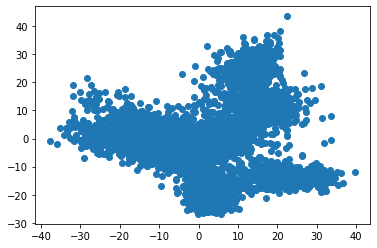

63.00560687837351
63.00560687837351
     pcost       dcost       gap    pres   dres
 0: -1.2368e+06 -8.7942e+08  1e+09  5e-02  4e-14
 1: -1.1613e+06 -8.5757e+08  1e+09  5e-02  4e-14
 2: -2.1330e+05 -7.4542e+08  9e+08  3e-02  2e-13
 3: -1.7677e+05 -5.1164e+07  5e+07  2e-15  4e-14
 4: -2.4021e+05 -1.1493e+07  1e+07  1e-15  5e-14
 5: -3.3922e+05 -1.1402e+07  1e+07  7e-16  5e-14
 6: -5.0998e+05 -1.0374e+07  1e+07  1e-15  4e-14
 7: -5.4588e+05 -1.0188e+07  1e+07  2e-15  3e-14
 8: -7.4232e+05 -9.0679e+06  8e+06  3e-15  1e-14
 9: -9.6163e+05 -4.5615e+06  4e+06  9e-16  2e-15
10: -1.0866e+06 -3.1508e+06  2e+06  2e-15  2e-15
11: -1.1239e+06 -2.6534e+06  2e+06  3e-16  1e-15
12: -1.1718e+06 -1.7884e+06  6e+05  2e-15  7e-16
13: -1.1905e+06 -1.5301e+06  3e+05  3e-16  5e-16
14: -1.2285e+06 -1.4459e+06  2e+05  1e-15  4e-16
15: -1.2455e+06 -1.3132e+06  7e+04  1e-15  4e-16
16: -1.2529e+06 -1.2729e+06  2e+04  2e-16  3e-16
17: -1.2556e+06 -1.2615e+06  6e+03  8e-16  4e-16
18: -1.2565e+06 -1.2584e+06  2e+03

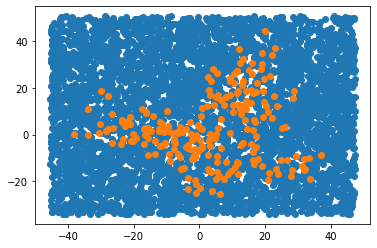

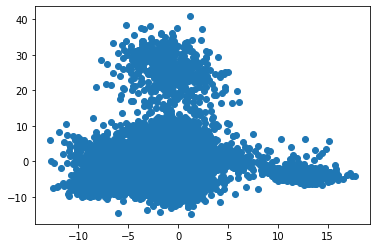

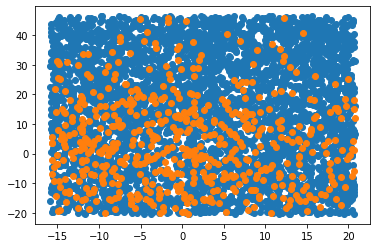

In [413]:
idx1=1
idx2=3
theta = 0.9
plt.scatter(result_mnist_train_subset[:, idx1], result_mnist_train_subset[:, idx2])
plt.show()

plt.scatter(temp_enri[np.squeeze(temp_coef) < theta, idx1], temp_enri[np.squeeze(temp_coef)< theta, idx2])
plt.scatter(temp_enri[np.squeeze(temp_coef)>= theta, idx1], temp_enri[np.squeeze(temp_coef)>= theta, idx2])
plt.show()

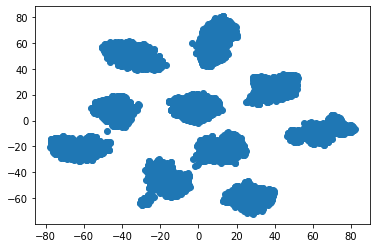

     pcost       dcost       gap    pres   dres
 0: -1.3993e+03 -1.1034e+06  1e+06  6e-16  4e-14
 1: -1.4079e+03 -2.7020e+04  3e+04  7e-16  8e-15
 2: -1.5387e+03 -4.5986e+03  3e+03  5e-16  8e-16
 3: -1.6368e+03 -2.1096e+03  5e+02  6e-16  2e-16
 4: -1.6686e+03 -1.7225e+03  5e+01  2e-16  2e-16
 5: -1.6757e+03 -1.6854e+03  1e+01  4e-16  2e-16
 6: -1.6774e+03 -1.6787e+03  1e+00  2e-16  1e-16
 7: -1.6777e+03 -1.6779e+03  2e-01  1e-16  1e-16
 8: -1.6778e+03 -1.6778e+03  2e-02  3e-16  1e-16
 9: -1.6778e+03 -1.6778e+03  2e-03  5e-17  1e-16
10: -1.6778e+03 -1.6778e+03  2e-04  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0757e+01 -1.1013e+06  1e+06  2e-16  9e-14
 1: -1.8590e+01 -2.6231e+04  3e+04  1e-16  3e-14
 2: -1.5268e+02 -2.9913e+03  3e+03  3e-16  2e-15
 3: -3.0285e+02 -4.5686e+02  2e+02  2e-16  6e-16
 4: -3.1682e+02 -4.3087e+02  1e+02  2e-16  4e-16
 5: -2.6992e+02 -3.9134e+02  1e+02  2e-16  1e-15
 6: -3.1525e+02 -3.2368e+02  8e+00  2e-16  3e-1

In [275]:
result_mnist_train_subset = result_mnist_train[:5000]
pred_label = result_mnist_train.argmax(axis=1)[:5000]
X_embedded = TSNE(n_components=2).fit_transform(result_mnist_train_subset)

plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

sample_enri_list = []
sample_coef_list = []

for label in range(10):
    temp_enri, temp_coef = sample_enrichment(label, X_embedded[pred_label==label,:], 500)
    sample_enri_list.append(temp_enri)
    sample_coef_list.append(np.squeeze(temp_coef))

sample_enri = np.vstack(sample_enri_list)
sample_coef = np.hstack(sample_coef_list)

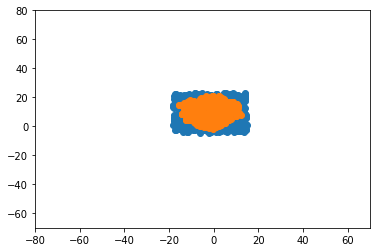

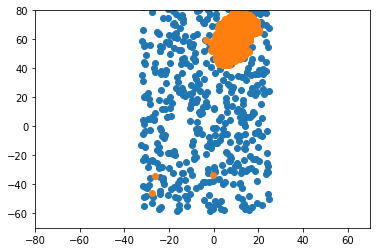

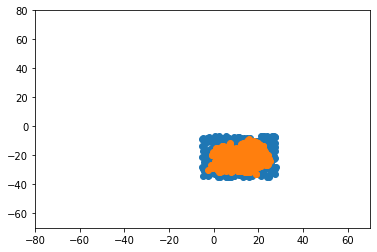

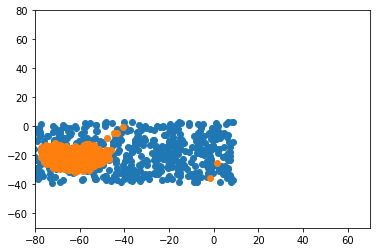

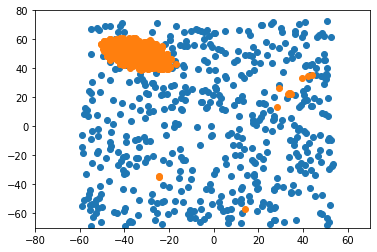

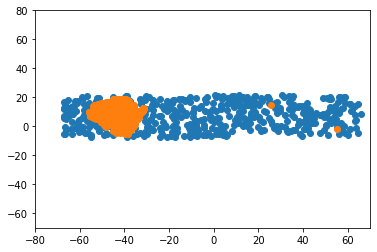

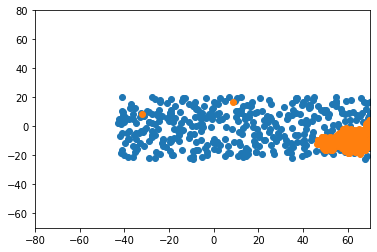

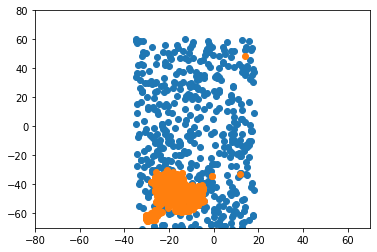

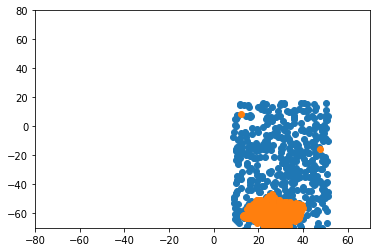

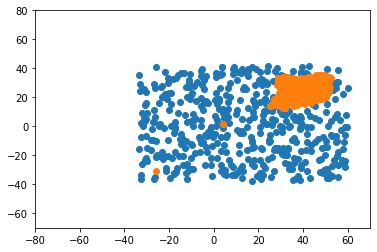

In [289]:

for i in range(10):
    label = i
    plt.scatter(sample_enri_list[label][:,0], sample_enri_list[label][:,1])
    plt.scatter(X_embedded[pred_label==label,0], X_embedded[pred_label==label,1])

    plt.xlim([-80, 70])
    plt.ylim([-70, 80])
    plt.show()

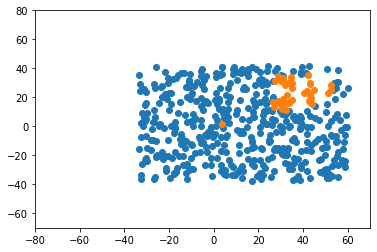

In [318]:
label = 0
theta = 0.9

plt.scatter(sample_enri_list[label][sample_coef_list[label]<theta,0], sample_enri_list[label][sample_coef_list[label]<theta,1])
plt.scatter(sample_enri_list[label][sample_coef_list[label]>=theta,0], sample_enri_list[label][sample_coef_list[label]>=theta,1])

plt.xlim([-80, 70])
plt.ylim([-70, 80])
plt.show()

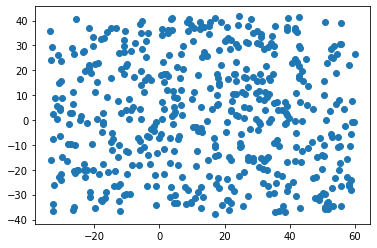

In [279]:
plt.scatter(temp_enri[:, 0], temp_enri[:, 1])
plt.show()

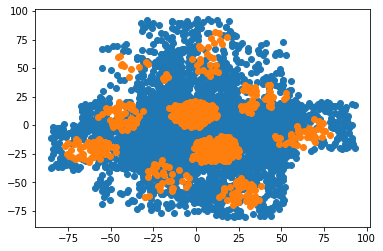

In [320]:
inlier_idx = sample_coef >= 0.9
oulier_idx = sample_coef < 0.9

plt.scatter(sample_enri[oulier_idx, 0], sample_enri[oulier_idx, 1])
plt.scatter(sample_enri[inlier_idx, 0], sample_enri[inlier_idx, 1])
plt.show()

In [225]:
sample_enri_list = []
sample_coef_list = []

pred_label = result_mnist_train.argmax(axis=1)

for c_idx in range(1):
    temp_enri, temp_coef = sample_enrichment(c_idx, result_mnist_train[pred_label==c_idx,:], 5000)
    sample_enri_list.append(temp_enri)
    sample_coef_list.append(np.squeeze(temp_coef))

     pcost       dcost       gap    pres   dres
 0:  2.5035e+03 -3.5174e+07  4e+07  5e-15  4e-10
 1:  2.4920e+03 -6.3383e+05  6e+05  6e-15  2e-11
 2:  2.3537e+03 -1.3644e+04  2e+04  1e-14  1e-13
 3:  1.8477e+03 -1.1128e+04  1e+04  7e-15  7e-14
 4:  3.2410e+03 -1.0109e+04  1e+04  1e-14  3e-12
 5:  2.3614e+03 -6.8441e+03  9e+03  4e-15  1e-12
 6:  1.8478e+03 -2.2799e+03  4e+03  1e-14  3e-13
 7:  1.8437e+03  1.7259e+03  1e+02  2e-14  3e-13
 8:  1.8429e+03  1.8417e+03  1e+00  1e-14  1e-13
 9:  1.8429e+03  1.8429e+03  1e-02  7e-15  4e-13
10:  1.8429e+03  1.8429e+03  1e-04  1e-14  2e-13
Optimal solution found.


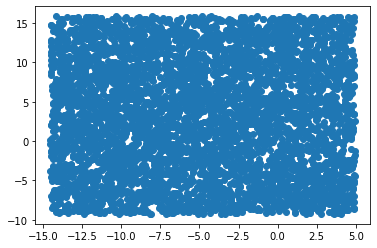

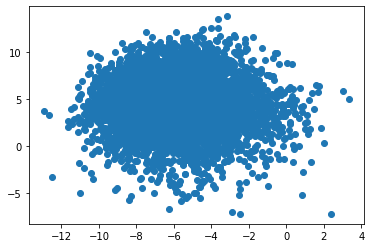

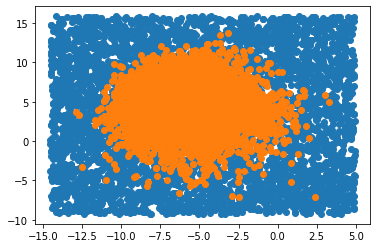

In [177]:
idx1 = 1
idx2 = 6
plt.scatter(sample_enri_list[0][:,idx1], sample_enri_list[0][:,idx2])
plt.show()
plt.scatter(result_mnist_train[pred_label==0,idx1], result_mnist_train[pred_label==0,idx2])
plt.show()
plt.scatter(sample_enri_list[0][:,idx1], sample_enri_list[0][:,idx2])
plt.scatter(result_mnist_train[pred_label==0,idx1], result_mnist_train[pred_label==0,idx2])
plt.show()

In [237]:
(sample_coef_list[0] > top_value).sum()

4297

In [238]:
(sample_coef_list[0] <= top_value).sum()

703

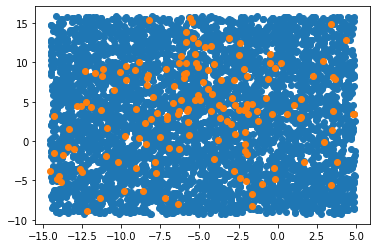

In [255]:
sorted_coef = np.array(sample_coef_list[0])
top_rate =  0.9949999
n = sorted_coef.shape[0]
(-sorted_coef).sort()
top_value = sorted_coef[:int(n*top_rate)][-1]

plt.scatter(sample_enri_list[0][sample_coef_list[0] <= top_value,idx1], sample_enri_list[0][sample_coef_list[0] <= top_value,idx2])
plt.scatter(sample_enri_list[0][sample_coef_list[0] > top_value,idx1], sample_enri_list[0][sample_coef_list[0] > top_value,idx2])
plt.show()

In [167]:
from sklearn.manifold import TSNE

In [168]:
X_embedded2 = TSNE(n_components=2).fit_transform(np.vstack([result_mnist_train[pred_label==0,:], sample_enri_list[0]]))

In [172]:
(pred_label==0).sum()

5879

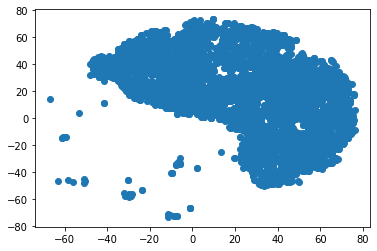

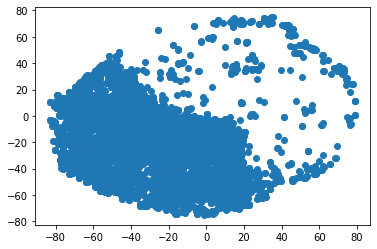

In [175]:
plt.scatter(X_embedded2[:5879,0], X_embedded2[:5879,1])
plt.show()
plt.scatter(X_embedded2[5879:12000,0], X_embedded2[5879:12000,1])
plt.show()

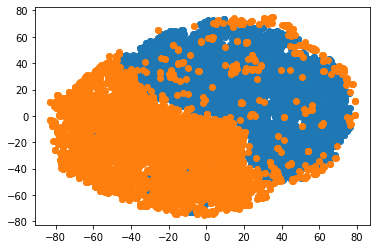

In [128]:
X_embedded = TSNE(n_components=2).fit_transform(np.vstack([result_mnist_train, sample_enri]))

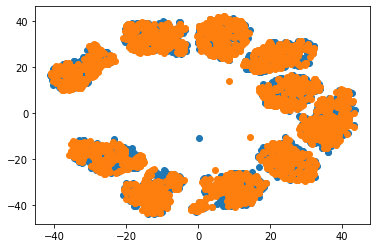

In [129]:
plt.scatter(X_embedded[:2000,0], X_embedded[:2000,1])
plt.scatter(X_embedded[10000:12000,0], X_embedded[10000:12000,1])
plt.show()

In [105]:
sample_enri

array([[  5.39951229,   9.93522404,  14.27326176, ...,  30.5717352 ,
         32.32338052,  -3.03122636],
       [ 18.09928098,   3.07937748,  12.07835943, ...,  27.03456521,
         22.92740108,  23.42456487],
       [ 27.87033503,  13.02538559,   5.34137247, ...,  33.73474226,
          9.94524088,  -1.33371135],
       ...,
       [-14.84657587,  12.52990802, -20.97497011, ..., -15.44102759,
         11.84615533,  13.80414916],
       [-22.22580723,  -6.54151708, -10.85623741, ..., -11.60953579,
         28.80827915, -15.62811724],
       [ 25.01717044,  12.59969247,  10.48874361, ...,  22.98495055,
        -14.60260264,  23.92333508]])

In [103]:
sample_enri.shape

(10000, 10)

In [102]:
np.unique(sample_coef)

array([0.85857864, 0.85857864, 0.85857864, 0.85857864, 0.85857864,
       0.85857864, 0.85857864, 0.85857864, 0.85857864, 0.85857864,
       0.85857864, 0.85857864])

In [100]:
plt.hist(sample_coef)
plt.show()

array([[ -1.8699542 ,   2.1465178 ,   3.9273689 , ...,  18.585032  ,
         -3.3776054 ,   0.32837433],
       [  0.7685867 ,   1.126144  ,  20.749798  , ...,  -1.9824831 ,
          1.1520731 , -10.4860935 ],
       [ -2.7816308 ,  12.392954  ,  -0.79940444, ...,   1.8422198 ,
         -2.021648  ,  -1.991739  ],
       ...,
       [-10.547281  ,  -0.17303637, -11.298429  , ...,   5.445765  ,
          0.7694205 ,   5.009863  ],
       [ -2.3330815 ,  -5.5819254 ,  -5.722374  , ...,  -7.907276  ,
          0.10180654,  -0.17642798],
       [ -1.6211001 ,  -3.4713502 ,  -0.5278998 , ...,  -6.597073  ,
          0.31539539, -11.397902  ]], dtype=float32)

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

In [86]:
outlier_detector_sampled = GradientBoostingClassifier(n_estimators=500,
                                                      learning_rate=0.01,
                                                      max_depth=20,
                                                      random_state=0)
outlier_detector_sampled.fit(sample_enri, sample_label)

ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

In [371]:
outlier_pred_result = outlier_detector_sampled.predict(result_merge_TSNE_embedded[:5000])
(outlier_pred_result == -1).sum()

3170

In [372]:
outlier_pred_result = outlier_detector_sampled.predict(result_merge_TSNE_embedded[5000:])
(outlier_pred_result == -1).sum()

2527

In [334]:
mnist_max = result_mnist_test.max(axis=0)
mnist_min = result_mnist_test.min(axis=0)

print(mnist_max)
print(mnist_min)

tsne_encoder = TSNE(n_components=3)
result_mnist_TSNE_embedded = tsne_encoder.fit_transform(result_mnist_test)

mnist_max = result_mnist_TSNE_embedded.max(axis=0)
mnist_min = result_mnist_TSNE_embedded.min(axis=0)

[32.462914 17.449823 40.792706 30.148672 27.773624 33.651993 39.696632
 37.301544 23.719337 22.675407]
[-49.111565 -56.339226 -37.01517  -44.560562 -72.01297  -38.27874
 -70.189766 -42.82456  -44.904865 -88.76575 ]


In [286]:
sample_size = 20000
sample_dim = mnist_max.shape[0]
uniform_sample_set = np.random.random(size =(sample_size, sample_dim))
uniform_sample_set

array([[0.2465011 , 0.81223087, 0.81335139],
       [0.72014925, 0.31200788, 0.50032272],
       [0.41372465, 0.29674057, 0.92818708],
       ...,
       [0.31822653, 0.23611348, 0.70696301],
       [0.6426144 , 0.8148847 , 0.83837668],
       [0.02015046, 0.52700754, 0.52643749]])

In [287]:
mnist_gap = mnist_max*2 - mnist_min*2
for dim_idx in range(sample_dim):
    uniform_sample_set[:, dim_idx] = uniform_sample_set[:, dim_idx] * mnist_gap[dim_idx] - mnist_gap[dim_idx]/2
uniform_sample_set

array([[-20.73815294,  25.586411  ,  28.17573432],
       [ 18.00989539, -15.40540735,   0.02901853],
       [ -7.05798494, -16.65651893,  38.5014581 ],
       ...,
       [-14.87046305, -21.62473248,  18.60957035],
       [ 11.66695039,  25.8038853 ,  30.42594194],
       [-39.25536938,   2.21318915,   2.37718971]])

In [288]:
coef = kernel_mean_matching(result_mnist_TSNE_embedded, uniform_sample_set, kern='rbf', B=10)

     pcost       dcost       gap    pres   dres
 0: -7.1726e+04 -2.8214e+08  9e+08  7e-02  2e-11
 1: -7.2191e+04 -2.8173e+08  9e+08  7e-02  2e-11
 2: -6.6092e+04 -2.8496e+08  9e+08  7e-02  2e-11
 3:  2.0601e+04 -2.5919e+08  3e+08  8e-03  2e-12
 4:  1.2066e+04 -2.6046e+07  3e+07  2e-15  7e-13
 5:  1.1677e+04 -2.2426e+06  2e+06  3e-15  3e-13
 6:  4.7691e+03 -2.1157e+06  2e+06  3e-16  3e-13
 7: -6.8128e+03 -1.8872e+06  2e+06  1e-15  2e-13
 8: -2.1345e+04 -1.5015e+06  1e+06  2e-15  1e-13
 9: -3.4727e+04 -1.1394e+06  1e+06  2e-15  9e-14
10: -4.5555e+04 -8.0405e+05  8e+05  9e-16  4e-14
11: -5.2842e+04 -4.8831e+05  4e+05  7e-16  3e-14
12: -5.8571e+04 -2.4578e+05  2e+05  4e-16  1e-14
13: -6.1315e+04 -1.1095e+05  5e+04  1e-15  1e-15
14: -6.4194e+04 -1.1367e+05  5e+04  2e-15  1e-15
15: -6.1109e+04 -1.1103e+05  5e+04  3e-15  1e-15
16: -6.1571e+04 -9.3591e+04  3e+04  5e-16  1e-15
17: -6.4620e+04 -9.6794e+04  3e+04  2e-15  1e-15
18: -6.5116e+04 -6.8825e+04  4e+03  2e-15  1e-15
19: -6.5187e+04 -6.56

In [330]:
uniform_label = np.ones(sample_size)
uniform_label[np.squeeze(coef < 0.8)] = -1
(uniform_label == -1).sum()/sample_size

0.52415

In [331]:
from sklearn.ensemble import GradientBoostingClassifier

outlier_detector_sampled = GradientBoostingClassifier(n_estimators=500,
                                                      learning_rate=0.01,
                                                      max_depth=5,
                                                      random_state=0)
outlier_detector_sampled.fit(uniform_sample_set, uniform_label)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [332]:
outlier_pred_result = outlier_detector_sampled.predict(uniform_sample_set)
(outlier_pred_result == -1).sum()

15640

In [333]:
outlier_pred_result = outlier_detector_sampled.predict(result_mnist_TSNE_embedded)
(outlier_pred_result == -1).sum()

762

In [336]:
result_omniglot_test_tsne = tsne_encoder.transform(result_omniglot_test)

AttributeError: 'TSNE' object has no attribute 'transform'

In [ ]:
def outlier_detection(outlier_detector, mnist, omniglot, mnist_noise, noise):
    outlier_detector.fit(mnist)
    print(mnist.shape)
    
    outlier_mnist = outlier_detector.predict(mnist)
    outlier_omniglot = outlier_detector.predict(omniglot)
    outlier_mnist_noise = outlier_detector.predict(mnist_noise)
    outlier_noise = outlier_detector.predict(noise)

    print('mnist detection rate:', (outlier_mnist == -1).sum()/outlier_mnist.shape[0])
    print('omniglot detection rate:', (outlier_omniglot == -1).sum()/outlier_omniglot.shape[0])
    print('mnist_noise detection rate:', (outlier_mnist_noise == -1).sum()/outlier_mnist_noise.shape[0])
    print('noise detection rate:', (outlier_noise == -1).sum()/outlier_noise.shape[0])

    true_label = np.ones(10000)
    true_label[5000:] = -1
    omniglot_f1 = f1_score(true_label, np.concatenate([outlier_mnist,outlier_omniglot]), average='macro')
    mnist_noise_f1 = f1_score(true_label, np.concatenate([outlier_mnist,outlier_mnist_noise]), average='macro')
    noise_f1 = f1_score(true_label, np.concatenate([outlier_mnist,outlier_noise]), average='macro')

    playground_result = pd.DataFrame()
    playground_result['detector'] = ['LocalOutlierFactor']
    playground_result['omniglot'] = [omniglot_f1]
    playground_result['mnist_noise'] = [mnist_noise_f1]
    playground_result['noise'] = [noise_f1]

    return playground_result